# Calibrate radii

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import skeliner as sk

In [2]:
mesh_path = './data/720575940559047213.obj'
mesh = sk.io.load_mesh(mesh_path)

In [17]:
%timeit
skel = sk.skeletonize(
    geodesic_shell_count=200,
    mesh=mesh,
    unit="nm",
    detect_soma=False,
)

In [18]:
%timeit
sk.post.calibrate_radii(
    skel=skel,
    mesh=mesh,
    min_n_outer=20,
    min_frac_outer=0.33,
    min_verts_q_outer=75.,
    rays_num_outer=30,
    rays_thresh_outer=0.2,
    verbose=True,
    aggregate='median'
)

[skeliner.post] calibrate_radii                         … 0.00 s
      └─ Check for inner meshes in all nodes with min_n_verts_bulb>=29;
      └─ This is 25% of all nodes
[skeliner.post] calibrate_radii summary                 … 0.00 s
      └─ n_total=204
      └─ n_fallback=0=0%, 
      └─ n_full_centerline=168=82%, 
      └─ n_outer_centerline=36=18%; 
      └─ store='calibrated', base='trim'


In [19]:
np.unique(skel.extra['calibration']['radius_method'], return_counts=True)

(array(['full_centerline', 'outer_centerline'], dtype='<U16'),
 array([168,  36]))

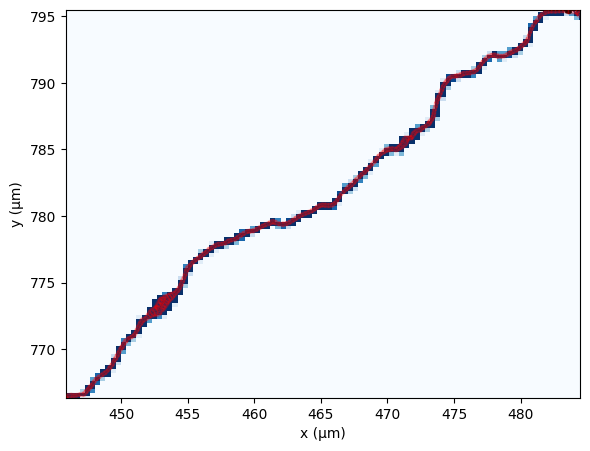

In [27]:
sk.plot.projection(skel=skel, mesh=mesh, draw_cylinders=True, plane='xy',
                   bins=101, cylinder_alpha=0.2, scale=1e-3, unit="μm");

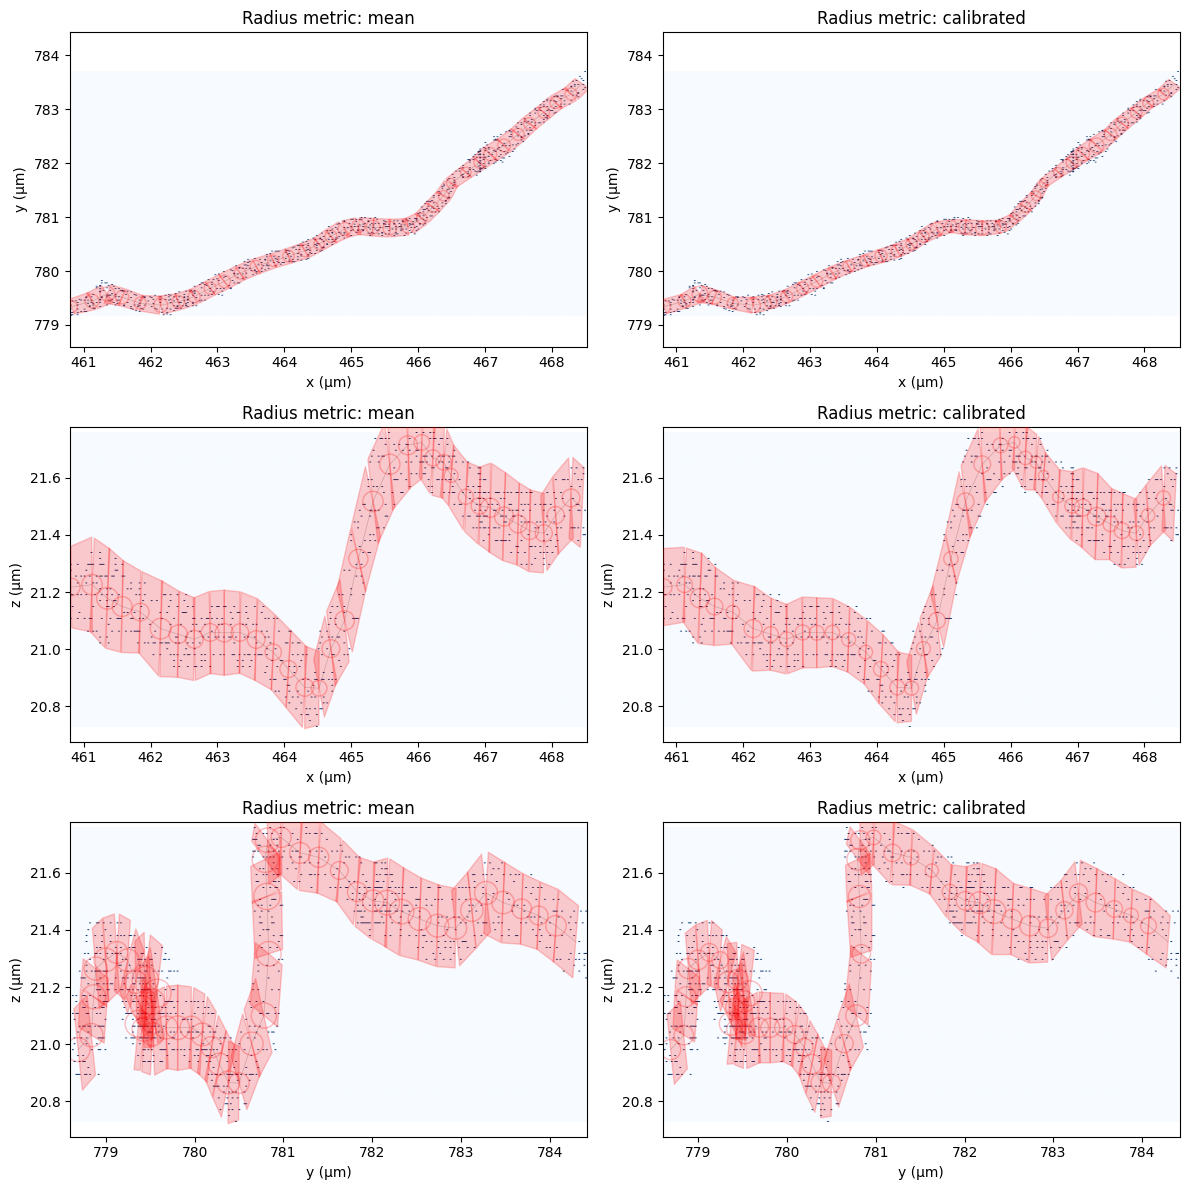

In [35]:
x_rng = (skel.nodes[:, 0].max() - skel.nodes[:, 0].min()) * 1e-3
y_rng = (skel.nodes[:, 1].max() - skel.nodes[:, 1].min()) * 1e-3
z_rng = (skel.nodes[:, 2].max() - skel.nodes[:, 2].min()) * 1e-3

xlim = (np.mean(skel.nodes[:, 0])*1e-3 - 0.1 * x_rng, np.mean(skel.nodes[:, 0])*1e-3 + 0.1 * x_rng)
ylim = (np.mean(skel.nodes[:, 1])*1e-3 - 0.1 * y_rng, np.mean(skel.nodes[:, 1])*1e-3 + 0.1 * y_rng)
zlim = (np.mean(skel.nodes[:, 2])*1e-3 - 0.2 * z_rng, np.mean(skel.nodes[:, 2])*1e-3 + 0.2 * z_rng)

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, metric in enumerate(['mean', 'calibrated']):

    for j, plane in enumerate(['xy', 'xz', 'yz']):
        ax = axs[j, i]
        if plane == 'xy':
            xlim_j, ylim_j = xlim, ylim
        elif plane == 'xz':
            xlim_j, ylim_j = xlim, zlim
        elif plane == 'yz':
            xlim_j, ylim_j = ylim, zlim
        else:
            raise ValueError(f"Unknown plane: {plane}")

        sk.plot.projection(ax=ax, skel=skel, mesh=mesh, plane=plane, radius_metric=metric,
                           draw_cylinders=True, bins=300,
                           xlim=xlim_j, ylim=ylim_j,
                           cylinder_alpha=0.2, scale=1e-3, unit="μm",)

        for ni in range(skel.nodes.shape[0]):
            if skel.extra['calibration']['radius_method'][ni] == 'outer_centerline':
                n_xyz = skel.nodes[ni]
                if plane == 'xy':
                    ax.plot(n_xyz[0], n_xyz[1], 'go', markersize=20, mfc='none')
                elif plane == 'xz':
                    ax.plot(n_xyz[0], n_xyz[2], 'go', markersize=20, mfc='none')
                elif plane == 'yz':
                    ax.plot(n_xyz[1], n_xyz[2], 'go', markersize=20, mfc='none')

        ax.set_aspect('auto', 'box')
        ax.set_title(f"Radius metric: {metric}")

plt.show()

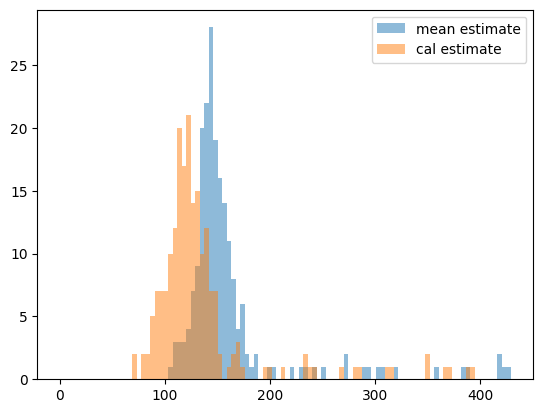

In [22]:
bins = np.linspace(0, np.max(skel.radii['mean']), 101)
plt.hist(skel.radii['mean'], alpha=0.5, bins=bins, label='mean estimate')
plt.hist(skel.radii['calibrated'], alpha=0.5, bins=bins, label='cal estimate')
plt.legend()
plt.show()

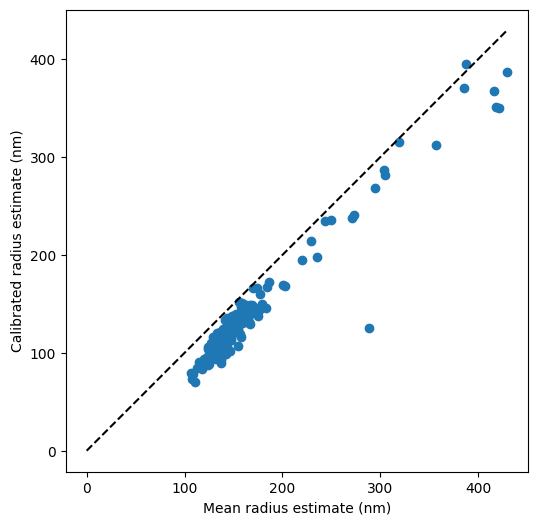

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(skel.radii['mean'], skel.radii['calibrated'])
ax.set_aspect('equal', 'box')
ax.plot([0, skel.radii['mean'].max()], [0, skel.radii['mean'].max()], 'k--')
ax.set(xlabel='Mean radius estimate (nm)', ylabel='Calibrated radius estimate (nm)')
plt.show()